In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('white')

import statsmodels.api as sm
import statsmodels.tsa.stattools as ts

import yfinance as yf

from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
from sklearn.gaussian_process.kernels import RBF, ExpSineSquared, RationalQuadratic, WhiteKernel
from sklearn.gaussian_process import GaussianProcessRegressor

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler

In [3]:
import gpytorch
import os
import torch

In [4]:
#SPY = SP500
tickers = ['SPY', 'AAL', 'AMZN', 'PFE', 'DB', 'WMT']

In [5]:
sp500 = yf.download(tickers[0], start='2012-01-01', end='2022-10-14')

[*********************100%***********************]  1 of 1 completed


In [6]:
sp500['ret'] = sp500['Adj Close'].pct_change()
sp500.dropna(inplace=True)

In [7]:
sp500.head()

,Open,High,Low,Close,Adj Close,Volume,ret
Date,,,,,,,
2012-01-04,127.199997,127.809998,126.709999,127.699997,104.235161,127186500,0.001569
2012-01-05,127.010002,128.229996,126.430000,128.039993,104.512688,173895000,0.002663
2012-01-06,128.199997,128.220001,127.290001,127.709999,104.243309,148050000,-0.002577
2012-01-09,128.000000,128.179993,127.410004,128.020004,104.496346,99530200,0.002427
2012-01-10,129.389999,129.649994,128.949997,129.130005,105.402412,115282000,0.008671


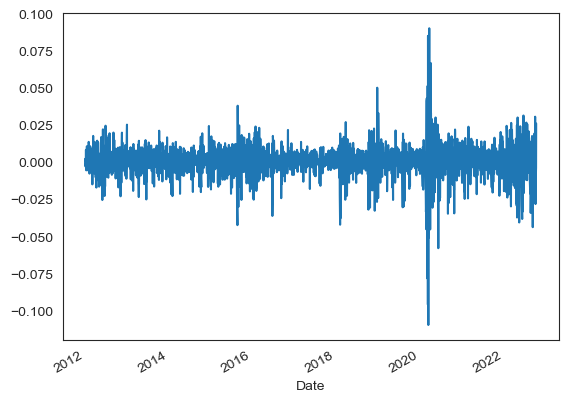

In [8]:
sp500['ret'].plot();

In [9]:
def generateLag(sp500, lags=3):
    for i in range(lags):
        sp500.loc['lag' + str(i+1)] = sp500['Close'].shift(i+1)
    return sp500

In [10]:
# sp500_lag = generateLag(sp500).dropna()

In [11]:
# sp500_lag.loc[sp500_lag.loc[:, 'ret'] > 0, 'dir'] = 1
# sp500_lag.loc[sp500_lag.loc[:, 'ret'] < 0, 'dir'] = -1

In [12]:
# sp500_lag.head()

In [13]:
sp500

,Open,High,Low,Close,Adj Close,Volume,ret
Date,,,,,,,
2012-01-04,127.199997,127.809998,126.709999,127.699997,104.235161,127186500,0.001569
2012-01-05,127.010002,128.229996,126.430000,128.039993,104.512688,173895000,0.002663
2012-01-06,128.199997,128.220001,127.290001,127.709999,104.243309,148050000,-0.002577
2012-01-09,128.000000,128.179993,127.410004,128.020004,104.496346,99530200,0.002427
2012-01-10,129.389999,129.649994,128.949997,129.130005,105.402412,115282000,0.008671
...,...,...,...,...,...,...,...
2022-10-07,368.970001,373.290009,360.940002,362.790009,362.790009,107789500,-0.027894
2022-10-10,363.959991,364.209991,357.670013,360.019989,360.019989,76042800,-0.007635
2022-10-11,358.239990,363.029999,355.709991,357.739990,357.739990,92482800,-0.006333


In [14]:
train = sp500.iloc[:int(sp500.shape[0]*0.8)]
test = sp500.iloc[int(sp500.shape[0]*0.8):]

In [15]:
# train['Adj Close'] = train['ret']
# test['Adj Close'] = test['ret']

In [16]:
train.shape, test.shape

((2170, 7), (543, 7))

<AxesSubplot:xlabel='Date'>

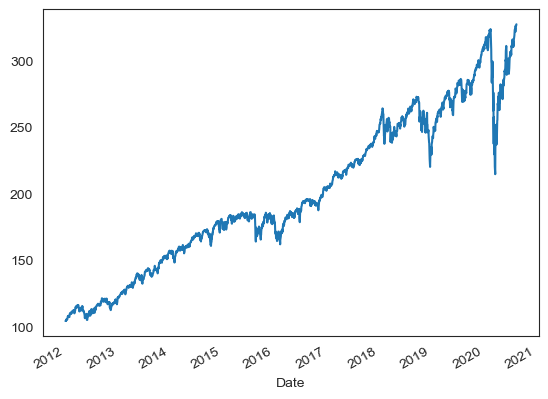

In [17]:
train['Adj Close'].plot()

# GP Regression

In [18]:
def plot_gp(x_pred, y_pred, sigmas, x_train, y_train, true_y=None, samples=None):
    """
    Function that plots the GP mean & std on top of given points.
    x_pred: points for prediction
    y_pred: means
    sigmas: std
    x, y: given data
    true_y: 
    samples: 2D numpy array with shape (# of points, # of samples)
    """
    if samples is not None:
        plt.plot(all_x.reshape(-1, 1), samples)
    
    plt.errorbar(x_pred, y_pred, yerr=sigmas, capsize=0, 
                 ecolor=(0.85, 0.85, 0.85), fmt = "r-", 
                 label="pred mean")
    plt.plot(x_train, y_train, "ko", label="training set")
    if true_y is not None:
        plt.plot(x_pred, true_y, "b-", label="truth function")
    plt.legend()

In [19]:
def convertTime(series):
    time = series.year  + (series.month * 30 + series.day) / 365
    return np.array(time)

## not normalize

In [20]:
long_term_trend_kernel = 252 * RBF(length_scale=1)
seasonal_kernel = (
    2.0**2
    * RBF(length_scale=100.0)
    * ExpSineSquared(length_scale=1.0, periodicity=1.0, periodicity_bounds="fixed")
)
irregularities_kernel = 0.5**2 * RationalQuadratic(length_scale=1.0, alpha=1.0)
noise_kernel = 0.1**2 * RBF(length_scale=0.1) + WhiteKernel(
    noise_level=0.1**2, noise_level_bounds=(1e-5, 1e5)
)
mix_kernel = (
    long_term_trend_kernel + seasonal_kernel + irregularities_kernel + noise_kernel
)

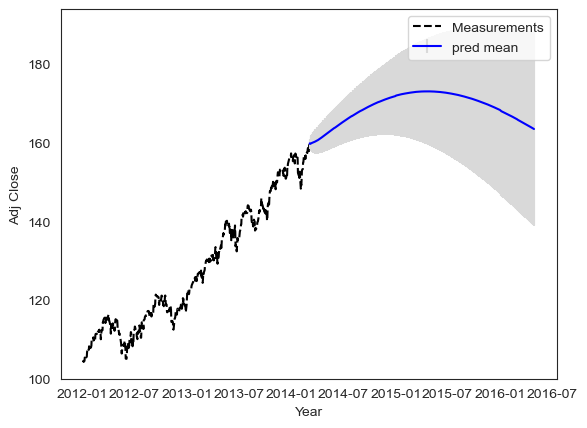

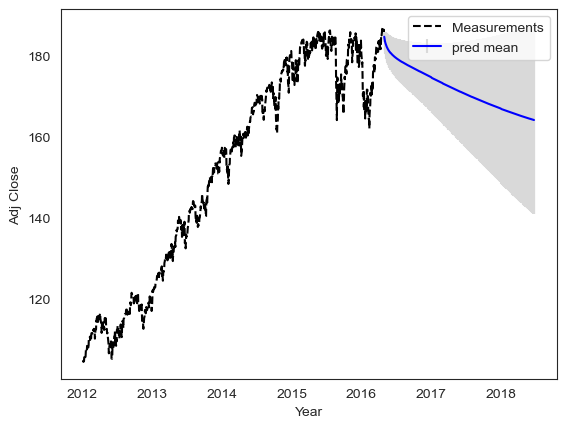

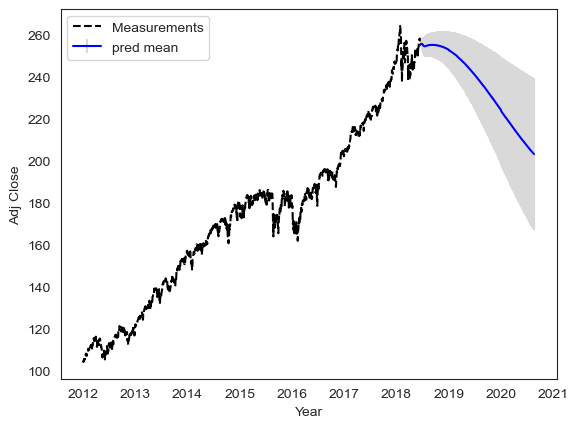

Mixed kernel, not normalized:
MAPE: 0.13098088979330622
MSE: 2043.4118115290457
MSLE: 0.040852968200819184


In [21]:
kernel = mix_kernel
tscv = TimeSeriesSplit(n_splits=3)
mapes = []
mses = []
msles = []
for train_index, test_index in tscv.split(train):
    split_train, split_test = train.iloc[train_index], train.iloc[test_index]

    X = convertTime(pd.to_datetime(split_train.index)).reshape(-1, 1)
    y = split_train['Adj Close'].to_numpy().reshape(-1, 1)
    y_mean = y.mean()
    X_test = convertTime(pd.to_datetime(split_test.index)).reshape(-1, 1)
    y_test = split_test['Adj Close'].to_numpy().reshape(-1, 1)

    gaussian_process = GaussianProcessRegressor(kernel=kernel, normalize_y=False, n_restarts_optimizer=10)
    gaussian_process.fit(X, y - y_mean)
    mean_y_pred, std_y_pred = gaussian_process.predict(X_test, return_std=True)
    mean_y_pred += y_mean
    plt.plot(split_train.index, split_train['Adj Close'], color="black", linestyle="dashed", label="Measurements")
    plt.errorbar(split_test.index, mean_y_pred.reshape(1, -1)[0], yerr=std_y_pred, capsize=0, 
                 ecolor=(0.85, 0.85, 0.85), fmt = "b-", 
                 label="pred mean")
    plt.legend()
    plt.xlabel("Year")
    plt.ylabel("Adj Close")
    plt.show();

    mapes.append(mean_absolute_percentage_error(y_test, mean_y_pred))
    mses.append(mean_squared_error(y_test, mean_y_pred))
    try:
        msles.append(mean_squared_log_error(y_test, mean_y_pred))
    except:
        continue

# loss function
print("Mixed kernel, not normalized:")
print("MAPE:", np.mean(mapes))
print("MSE:", np.mean(mses))
print("MSLE:", np.mean(msles))


## SM kernel

In [22]:
class SpectralMixtureGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(SpectralMixtureGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.SpectralMixtureKernel(num_mixtures=4)
        self.covar_module.initialize_from_data(train_x, train_y)

    def forward(self,x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)



In [23]:
def trainwSMkernel(train_x, train_y, test_x):
    
    
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = SpectralMixtureGPModel(train_x, train_y, likelihood)
    
    smoke_test = ('CI' in os.environ)
    training_iter = 2 if smoke_test else 100

    # Find optimal model hyperparameters
    model.train()
    likelihood.train()

    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(training_iter):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iter, loss.item()))
        optimizer.step()
    

    # Get into evaluation (predictive posterior) mode
    model.eval()
    likelihood.eval()

    # The gpytorch.settings.fast_pred_var flag activates LOVE (for fast variances)
    # See https://arxiv.org/abs/1803.06058

    # Make predictions
    observed_pred = likelihood(model(test_x)) 
    
    return observed_pred

Iter 1/100 - Loss: 171.900
Iter 2/100 - Loss: 159.475
Iter 3/100 - Loss: 148.203
Iter 4/100 - Loss: 138.010
Iter 5/100 - Loss: 128.801
Iter 6/100 - Loss: 120.517
Iter 7/100 - Loss: 113.060
Iter 8/100 - Loss: 106.328
Iter 9/100 - Loss: 100.224
Iter 10/100 - Loss: 94.690
Iter 11/100 - Loss: 89.683
Iter 12/100 - Loss: 85.158
Iter 13/100 - Loss: 81.061
Iter 14/100 - Loss: 77.342
Iter 15/100 - Loss: 73.942
Iter 16/100 - Loss: 70.808
Iter 17/100 - Loss: 67.892
Iter 18/100 - Loss: 65.158
Iter 19/100 - Loss: 62.584
Iter 20/100 - Loss: 60.154
Iter 21/100 - Loss: 57.862
Iter 22/100 - Loss: 55.704
Iter 23/100 - Loss: 53.678
Iter 24/100 - Loss: 51.782
Iter 25/100 - Loss: 50.008
Iter 26/100 - Loss: 48.347
Iter 27/100 - Loss: 46.785
Iter 28/100 - Loss: 45.300
Iter 29/100 - Loss: 43.859
Iter 30/100 - Loss: 42.408
Iter 31/100 - Loss: 40.871
Iter 32/100 - Loss: 39.156
Iter 33/100 - Loss: 37.186
Iter 34/100 - Loss: 34.940
Iter 35/100 - Loss: 32.471
Iter 36/100 - Loss: 29.898
Iter 37/100 - Loss: 27.369
I

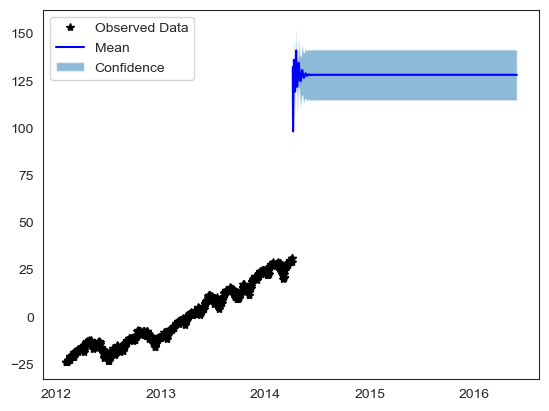

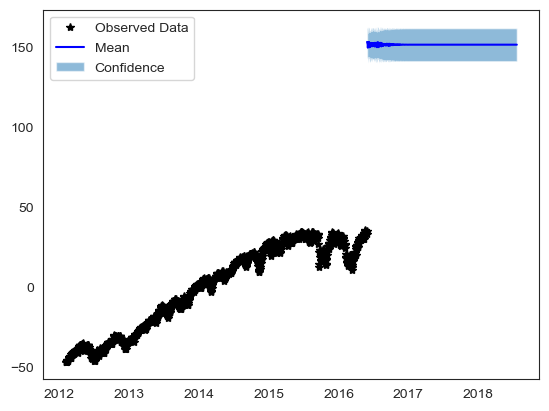

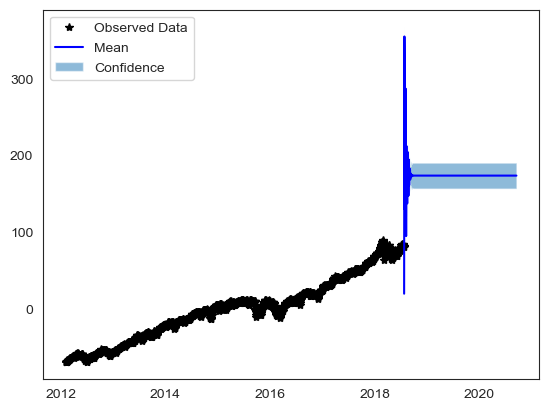

In [24]:

mapes = []
mses = []
msles = []

for train_index, test_index in tscv.split(train):
    split_train, split_test = train.iloc[train_index], train.iloc[test_index]
    X = convertTime(pd.to_datetime(split_train.index)).reshape(-1, 1)
    y = split_train['Adj Close'].to_numpy().reshape(-1, 1)
    y_mean = y.mean()
    X_test = convertTime(pd.to_datetime(split_test.index)).reshape(-1, 1)
    y_test = split_test['Adj Close'].to_numpy().reshape(-1, 1)

    train_x = torch.from_numpy(X.reshape(1, -1)[0])
    train_y = torch.from_numpy(y.reshape(1, -1)[0] - y_mean)
    test_x = torch.from_numpy(X_test.reshape(1, -1)[0]).float()
    
    observed_pred = trainwSMkernel(train_x, train_y, test_x)
    last_price = y[-1, 0]
    mean_y_pred = observed_pred.mean.detach().numpy() + y_mean
    
    mapes.append(mean_absolute_percentage_error(y_test, mean_y_pred))
    mses.append(mean_squared_error(y_test, mean_y_pred))
    try:
        msles.append(mean_squared_log_error(y_test, mean_y_pred))
    except:
        continue

    # Initialize plot
    f, ax = plt.subplots(1, 1)

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), mean_y_pred, 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.detach().numpy()+y_mean, upper.detach().numpy()+y_mean, alpha=0.5)
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    
# loss function
print("SM kernel:")
print("MAPE:", np.mean(mapes))
print("MSE:", np.mean(mses))
print("MSLE:", np.mean(msles))


# Augment X

In [25]:
def normalizeDataByYear(df):
    years = df.index.year.drop_duplicates()
    norm_y = pd.DataFrame()
    last_mean, last_std = None, None
    for year in years:
        year_mean = np.mean(df[str(year)]).values[0]
        year_std = np.std(df[str(year)]).values[0]
        temp = (df[str(year)] - year_mean) / year_std
        temp = temp - temp.iloc[0]
        norm_y = norm_y.append(temp, ignore_index=True)
        
        if year == years[-1]:
            last_mean, last_std = year_mean, year_std
            
    norm_y.index = df.index
    return norm_y, (last_mean, last_std)

In [26]:
def convertTime2(series):
    year = series.year  
    day = (series.month - 1) * 20 + series.day
    return np.array([year, day])

In [27]:
def getXpred(split_test):
    days_for_prediction = len(split_test)
    X_test = convertTime2(pd.to_datetime(split_test.index)).T
    pred_years = split_test.index.year.drop_duplicates()
    X_pred = np.empty([1, 2], dtype='float')
    for i in range(len(pred_years)):
        year = pred_years[i]
        year_x = X_test[X_test[:, 0] == year]
        len_year = len(year_x)
        x_mesh = np.linspace(year_x[0, 1], year_x[-1, 1], int(len_year / 252 * 2000))
        temp = np.array([[year, x_mesh[i]] for i in range(len(x_mesh))])
        if i == 0:
            X_pred = temp
        else:
            X_pred = np.append(X_pred, temp, axis=0)
    return X_pred

In [28]:
def convertBackNormY(y, last_mean, last_std):
    
    y = y * last_std + last_mean
    
    return y

In [29]:
def convertBackTime2(arr):
    
    year = series.year  
    day = series.month * 20 + series.day
    day = arr[:, 1] 
    
    return np.array([year, day])

In [30]:
def getEvenSpaceIdx(length, numElems):
    
#     pred_years = np.unique(X_pred[:, 0])
#     for i in range(len(pred_years)):
#         year = pred_years[i]
#         year_x = X_pred[X_pred[:, 0] == year]
#         numElems = len(year_x)

    idx = np.round(np.linspace(0, length - 1, numElems)).astype(int)
    
    return idx

In [31]:
def convertMeshedPredBack(X_pred, mean_y_pred, y_test):
    
    numElems = len(y_test)
    idx = getEvenSpaceIdx(len(X_pred), numElems)
    y_pred = mean_y_pred[idx]
    
    return y_pred

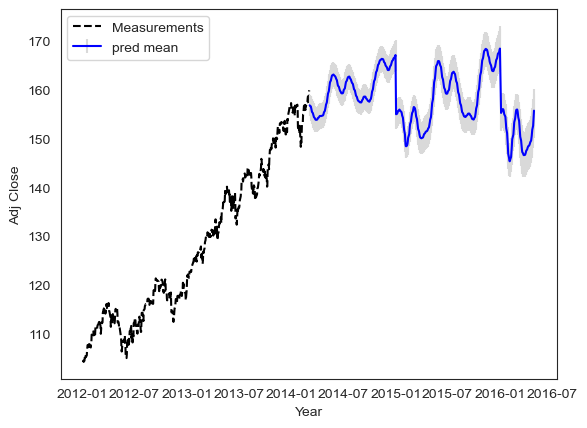

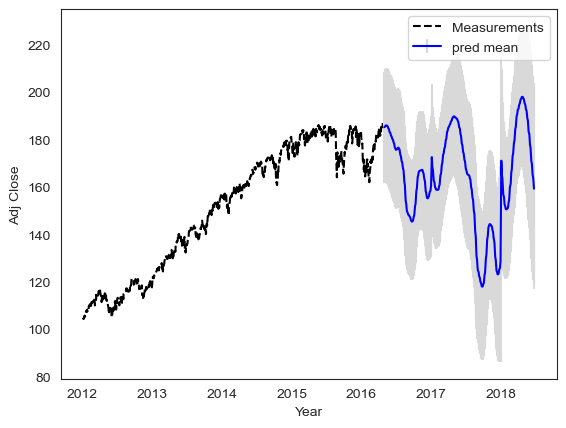

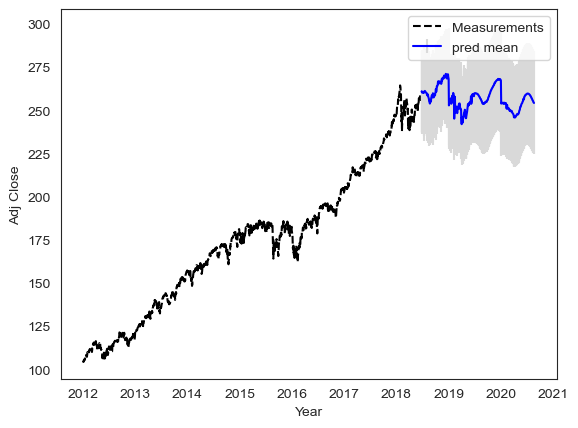

15.9**2 * RBF(length_scale=1) + 2**2 * RBF(length_scale=100) * ExpSineSquared(length_scale=1, periodicity=1) + 0.5**2 * RationalQuadratic(alpha=1, length_scale=1) + 0.1**2 * RBF(length_scale=0.1) + WhiteKernel(noise_level=0.01)
MAPE: 0.14250870286224518
MSE: 1822.9164257475204
MSLE: 0.04777397015278364


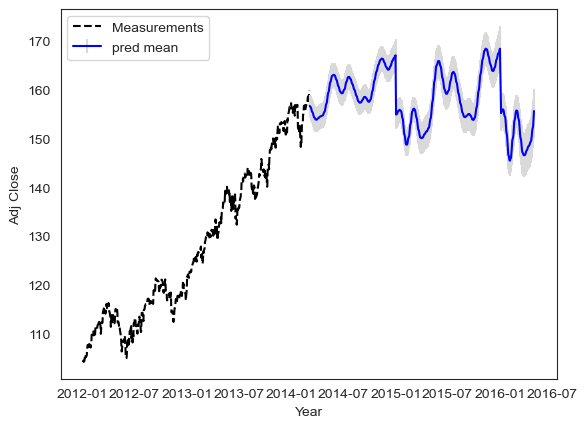

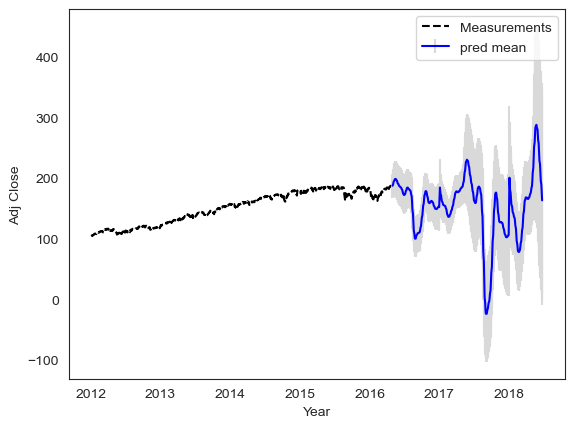

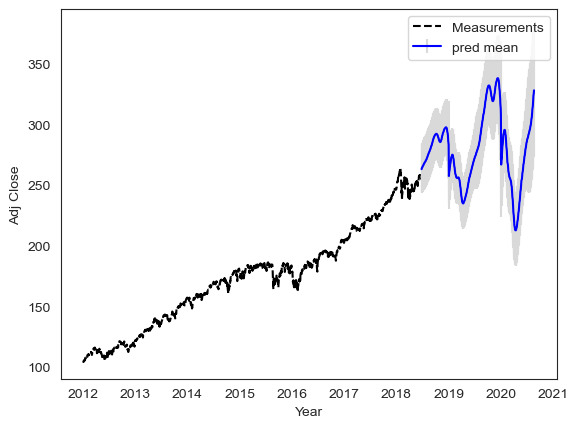

7.94**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1e-10)
MAPE: 0.16297754040821422
MSE: 3043.8218276329626
MSLE: 0.012349886687148745


In [32]:
simple_kernel = 63 * RBF(length_scale=1) + WhiteKernel(noise_level=1e-10)
kernels = [mix_kernel, simple_kernel]
preds = []
preds_std = []
for kernel in kernels:
    mapes = []
    mses = []
    msles = []

    for train_index, test_index in tscv.split(train):
        # three months
        split_train, split_test = train.iloc[train_index], train.iloc[test_index]
        X = convertTime2(pd.to_datetime(split_train.index)).T
        y, last_data = normalizeDataByYear(split_train[['Adj Close']])
        y = y.to_numpy().reshape(-1, 1)
        X_test = convertTime2(pd.to_datetime(split_test.index)).T
        y_test, _ = normalizeDataByYear(split_test[['Adj Close']])
        y_test = y_test.to_numpy().reshape(-1, 1)

        gaussian_process = GaussianProcessRegressor(kernel=kernel, normalize_y=False, n_restarts_optimizer=10)
        gaussian_process.fit(X.astype('float'), y)

        X_pred = getXpred(split_test)

        mean_y_pred, std_y_pred = gaussian_process.predict(X_pred, return_std=True)
        preds.append(mean_y_pred)
        preds_std.append(std_y_pred)

        mean_y_pred = convertBackNormY(mean_y_pred, last_data[0], last_data[1])
        y_pred = convertMeshedPredBack(X_pred, mean_y_pred, y_test)
        y_pred_std = convertMeshedPredBack(X_pred, std_y_pred, y_test) * last_data[1]**2

        plt.plot(split_train.index, split_train['Adj Close'], color="black", linestyle="dashed", label="Measurements")
        plt.errorbar(split_test.index, y_pred.reshape(1, -1)[0], yerr=y_pred_std, capsize=0, 
                     ecolor=(0.85, 0.85, 0.85), fmt = "b-", 
                     label="pred mean")
        plt.legend()
        plt.xlabel("Year")
        plt.ylabel("Adj Close")
        plt.show();

        mapes.append(mean_absolute_percentage_error(split_test[['Adj Close']], y_pred))
        mses.append(mean_squared_error(split_test[['Adj Close']], y_pred))
        try:
            msles.append(mean_squared_log_error(split_test[['Adj Close']], y_pred))
        except:
            continue

    # loss function
    print(kernel)
    print("MAPE:", np.mean(mapes))
    print("MSE:", np.mean(mses))
    print("MSLE:", np.mean(msles))

# Test

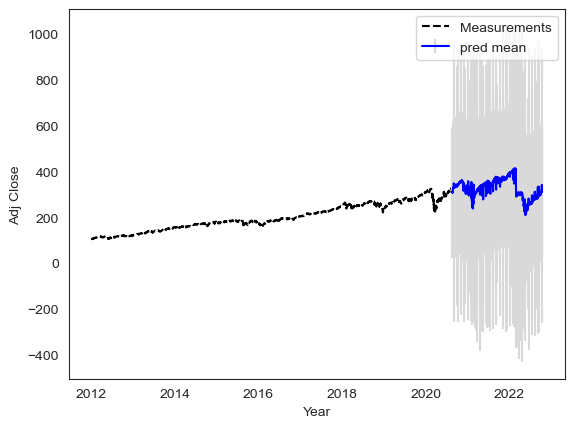

316**2 * RBF(length_scale=63.7) + 1.02**2 * RBF(length_scale=0.802) * ExpSineSquared(length_scale=2.47e+03, periodicity=1) + 0.00316**2 * RationalQuadratic(alpha=1e-05, length_scale=1.61e-05) + 0.00316**2 * RBF(length_scale=18.1) + WhiteKernel(noise_level=0.0935)


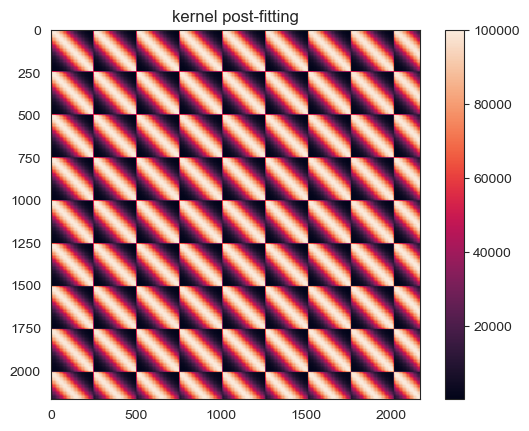

15.9**2 * RBF(length_scale=1) + 2**2 * RBF(length_scale=100) * ExpSineSquared(length_scale=1, periodicity=1) + 0.5**2 * RationalQuadratic(alpha=1, length_scale=1) + 0.1**2 * RBF(length_scale=0.1) + WhiteKernel(noise_level=0.01)
MAPE: 0.19349090282257364
MSE: 8061.757807693272
MSLE: 0.06610795422337368


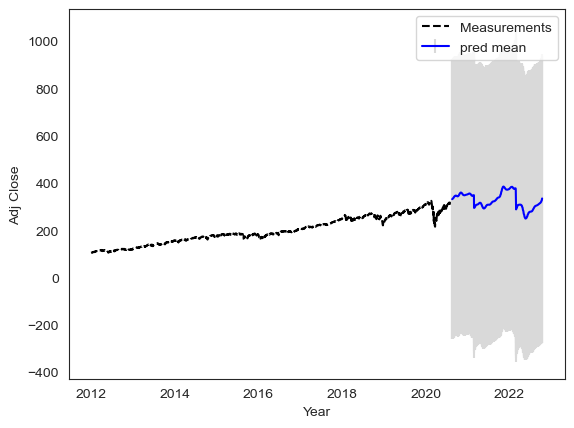

316**2 * RBF(length_scale=25.8) + WhiteKernel(noise_level=0.731)


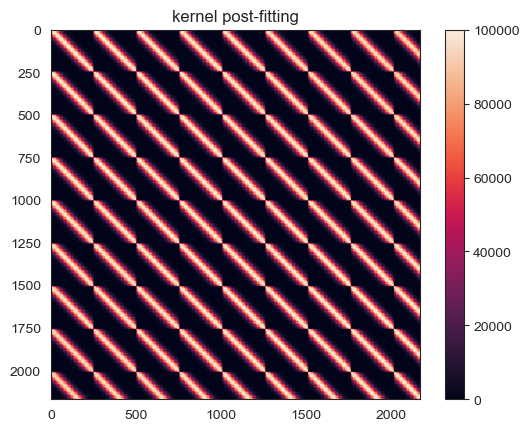

7.94**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1e-10)
MAPE: 0.19285034460959594
MSE: 8203.816858318172
MSLE: 0.06363064290472473


In [34]:
kernels = [mix_kernel, simple_kernel]
test_preds = []
test_preds_std = []
for kernel in kernels:
    # three months
    mapes = []
    mses = []
    msles = []

    X = convertTime2(pd.to_datetime(train.index)).T
    y, last_data = normalizeDataByYear(train[['Adj Close']])
    y = y.to_numpy().reshape(-1, 1)
    X_test = convertTime2(pd.to_datetime(test.index)).T
    y_test, _ = normalizeDataByYear(test[['Adj Close']])
    y_test = y_test.to_numpy().reshape(-1, 1)

    gaussian_process = GaussianProcessRegressor(kernel=kernel, normalize_y=False, n_restarts_optimizer=10)
    gaussian_process.fit(X.astype('float'), y)

    X_pred = getXpred(split_test)

    mean_y_pred, std_y_pred = gaussian_process.predict(X_pred, return_std=True)
    test_preds.append(mean_y_pred)
    test_preds_std.append(std_y_pred)

    mean_y_pred = convertBackNormY(mean_y_pred, last_data[0], last_data[1])
    y_pred = convertMeshedPredBack(X_pred, mean_y_pred, y_test)
    y_pred_std = convertMeshedPredBack(X_pred, std_y_pred, y_test) * last_data[1]**2

    plt.plot(train.index, train['Adj Close'], color="black", linestyle="dashed", label="Measurements")
    plt.errorbar(test.index, y_pred.reshape(1, -1)[0], yerr=y_pred_std, capsize=0, 
                 ecolor=(0.85, 0.85, 0.85), fmt = "b-", 
                 label="pred mean")
    plt.legend()
    plt.xlabel("Year")
    plt.ylabel("Adj Close")
    plt.show();

    # print the kernel with fitted parameters
    print(gaussian_process.kernel_)
    plt.figure()
    plt.imshow(gaussian_process.kernel_(X))
    plt.colorbar()
    plt.title('kernel post-fitting')
    plt.show();

    mapes.append(mean_absolute_percentage_error(test[['Adj Close']], y_pred))
    mses.append(mean_squared_error(test[['Adj Close']], y_pred))
    try:
        msles.append(mean_squared_log_error(test[['Adj Close']], y_pred))
    except:
        continue

    # loss function
    print(kernel)
    print("MAPE:", np.mean(mapes))
    print("MSE:", np.mean(mses))
    print("MSLE:", np.mean(msles))